In [53]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lane/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [40]:
def difference_of_gaussians_2d(center_sigma, surround_sigma, xmin=-5, xmax=5, spacing=100):
    mesh = np.meshgrid(np.linspace(xmin,xmax,spacing), np.linspace(xmin,xmax,spacing))
    center_gauss = gaussian(x=mesh[0], mu=0.0, sigma=center_sigma) * gaussian(
        x=mesh[1], mu=0.0, sigma=center_sigma)
    surround_gauss = gaussian(x=mesh[0], mu=0.0, sigma=surround_sigma) * gaussian(
        x=mesh[1], mu=0.0, sigma=surround_sigma)
    return center_gauss/np.sum(center_gauss) - surround_gauss/np.sum(surround_gauss)

/home/lane/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


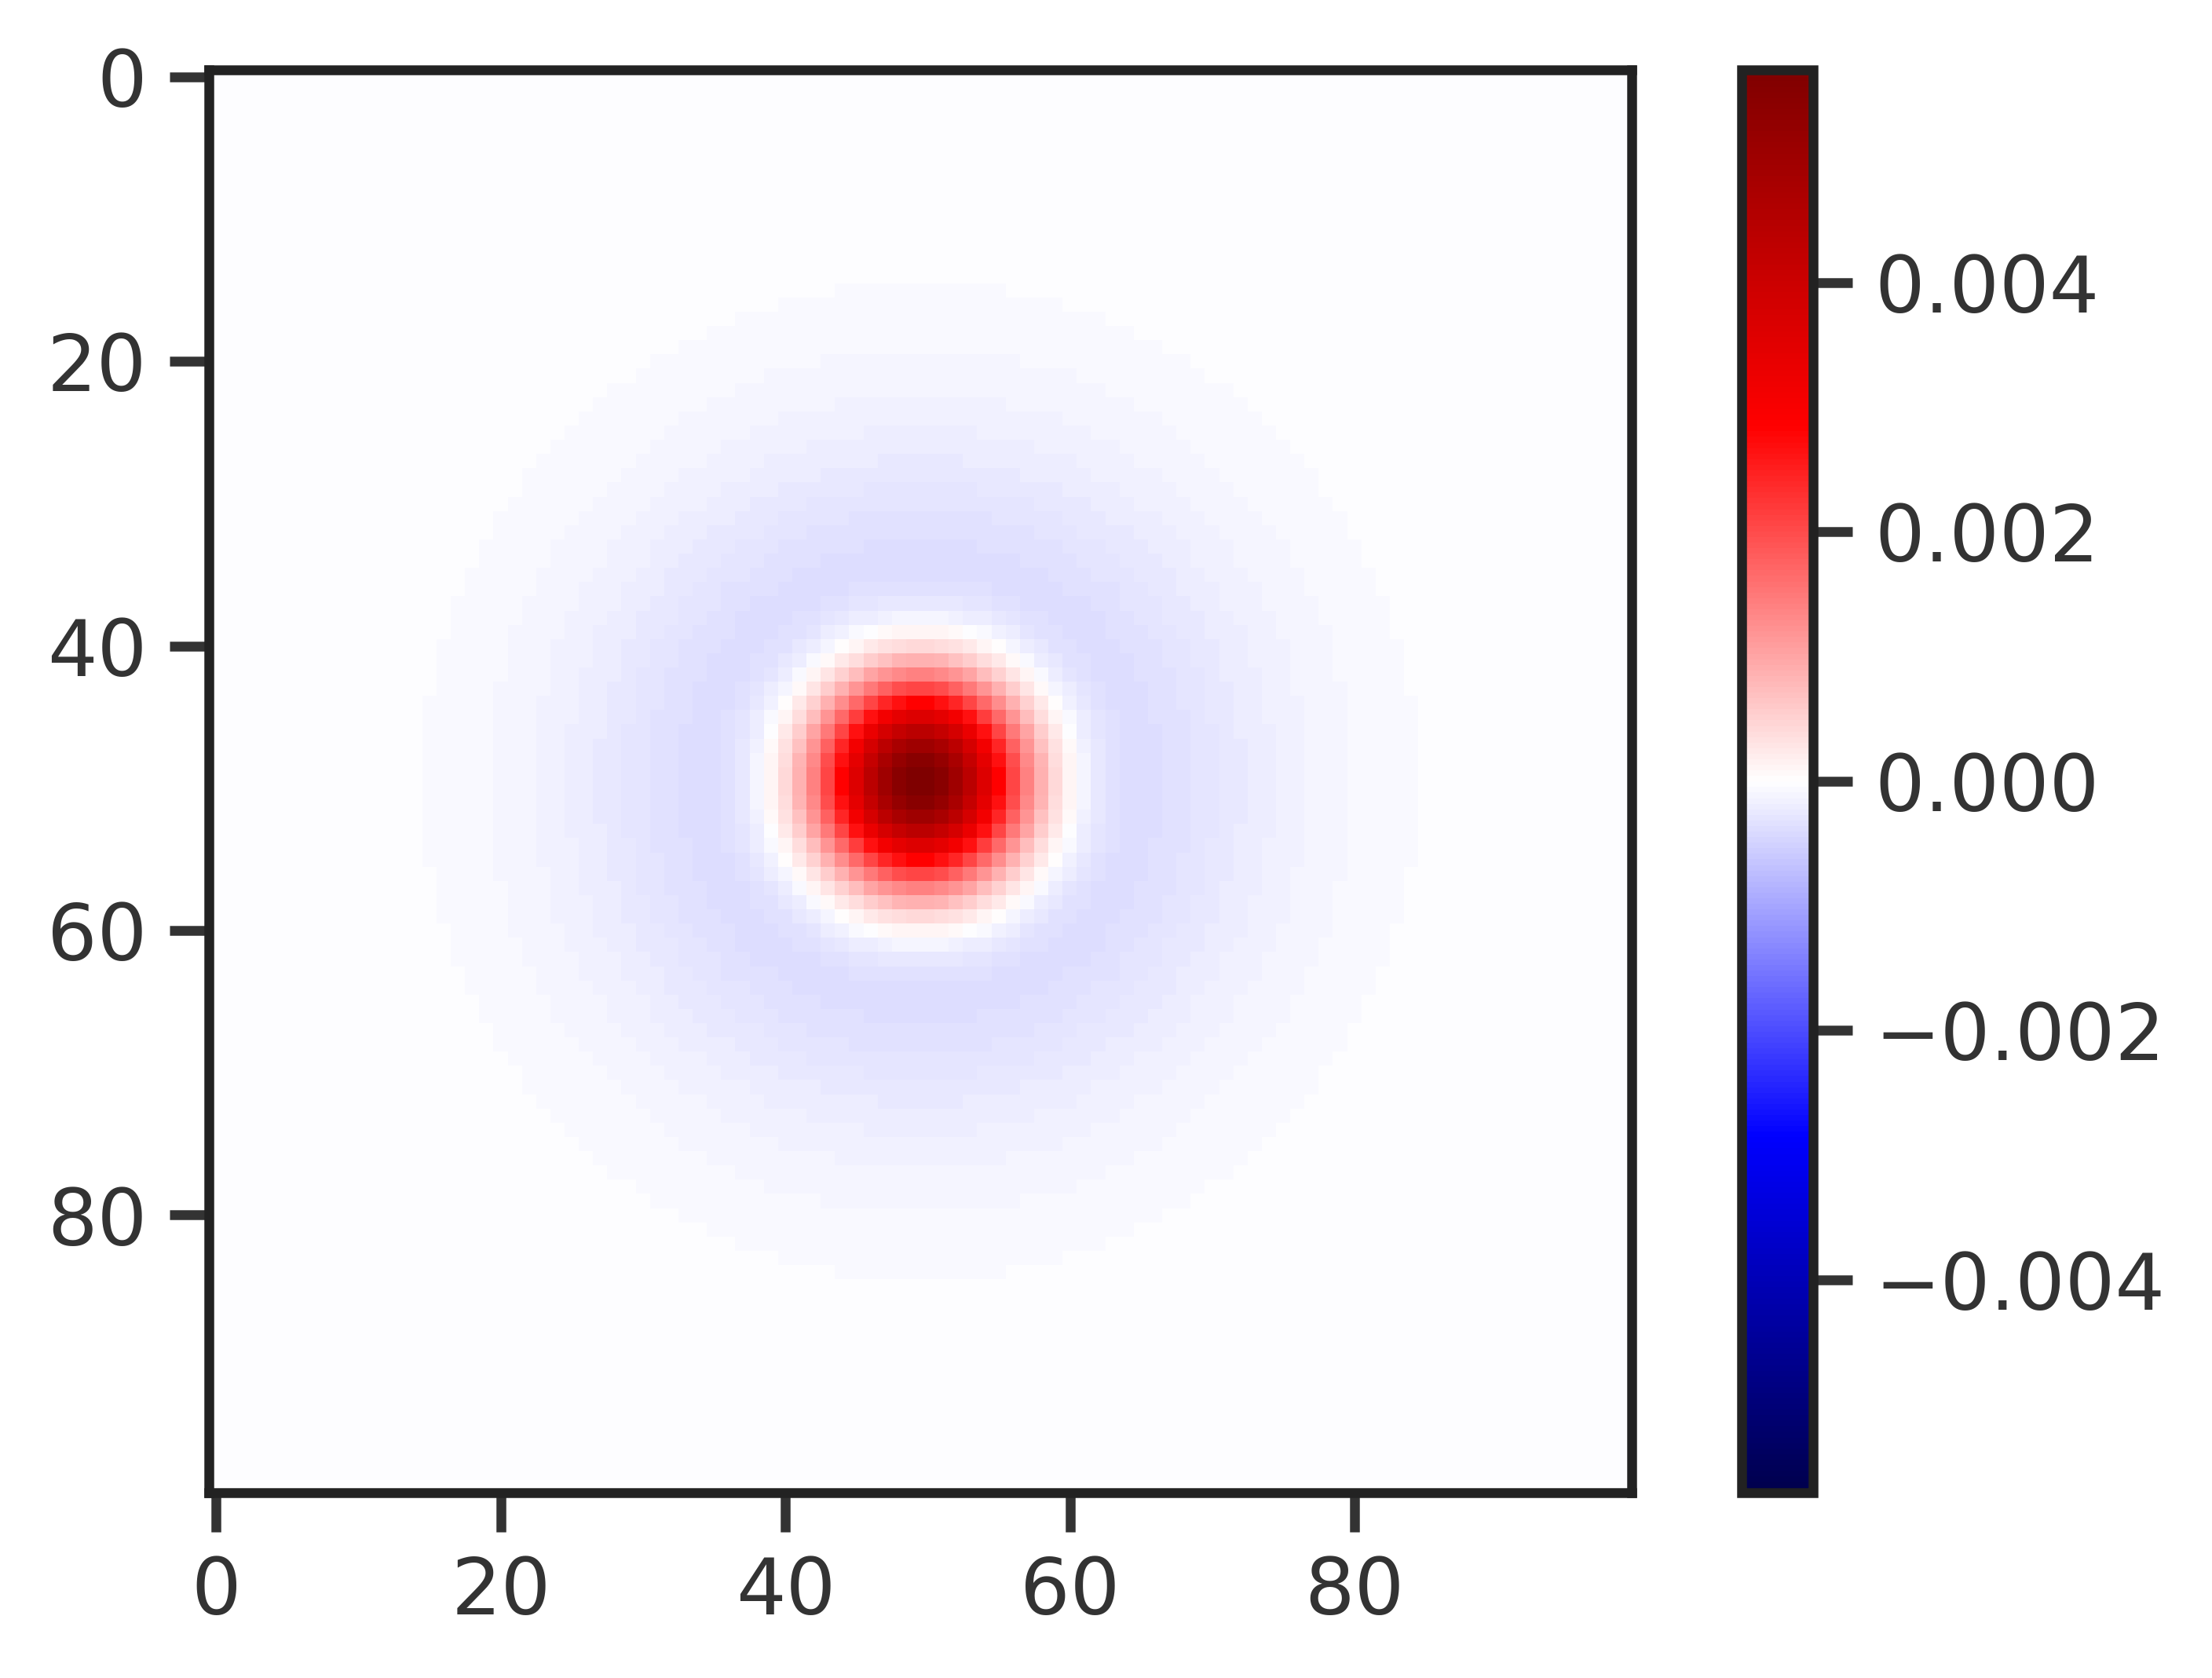

In [47]:
filt = difference_of_gaussians_2d(0.5, 1.5)
plt.imshow(filt, cmap='seismic', clim=[-np.max(abs(filt)), np.max(abs(filt))])
plt.colorbar()

In [82]:
homogenous_filters = [difference_of_gaussians_2d(0.5, 1.5),
                      difference_of_gaussians_2d(0.5, 1.5),
                      difference_of_gaussians_2d(0.5, 1.5)]
diverse_filters = [difference_of_gaussians_2d(0.5, 1.5),
                   difference_of_gaussians_2d(0.2, 1.0),
                   difference_of_gaussians_2d(0.5, 4.0)]
homogenous_image_data = [np.stack([convolve2d(patch,
                                              filt,
                                              mode='valid') for filt in homogenous_filters]) for patch in patches]
diverse_image_data = [np.stack([convolve2d(patch,
                                           filt,
                                           mode='valid') for filt in diverse_filters]) for patch in patches]

In [56]:
homogenous_image_data[0].shape

(3, 1006, 1006)

In [57]:
diverse_image_data[0].shape

(3, 1006, 1006)

In [58]:
len(diverse_image_data)

70

/home/lane/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


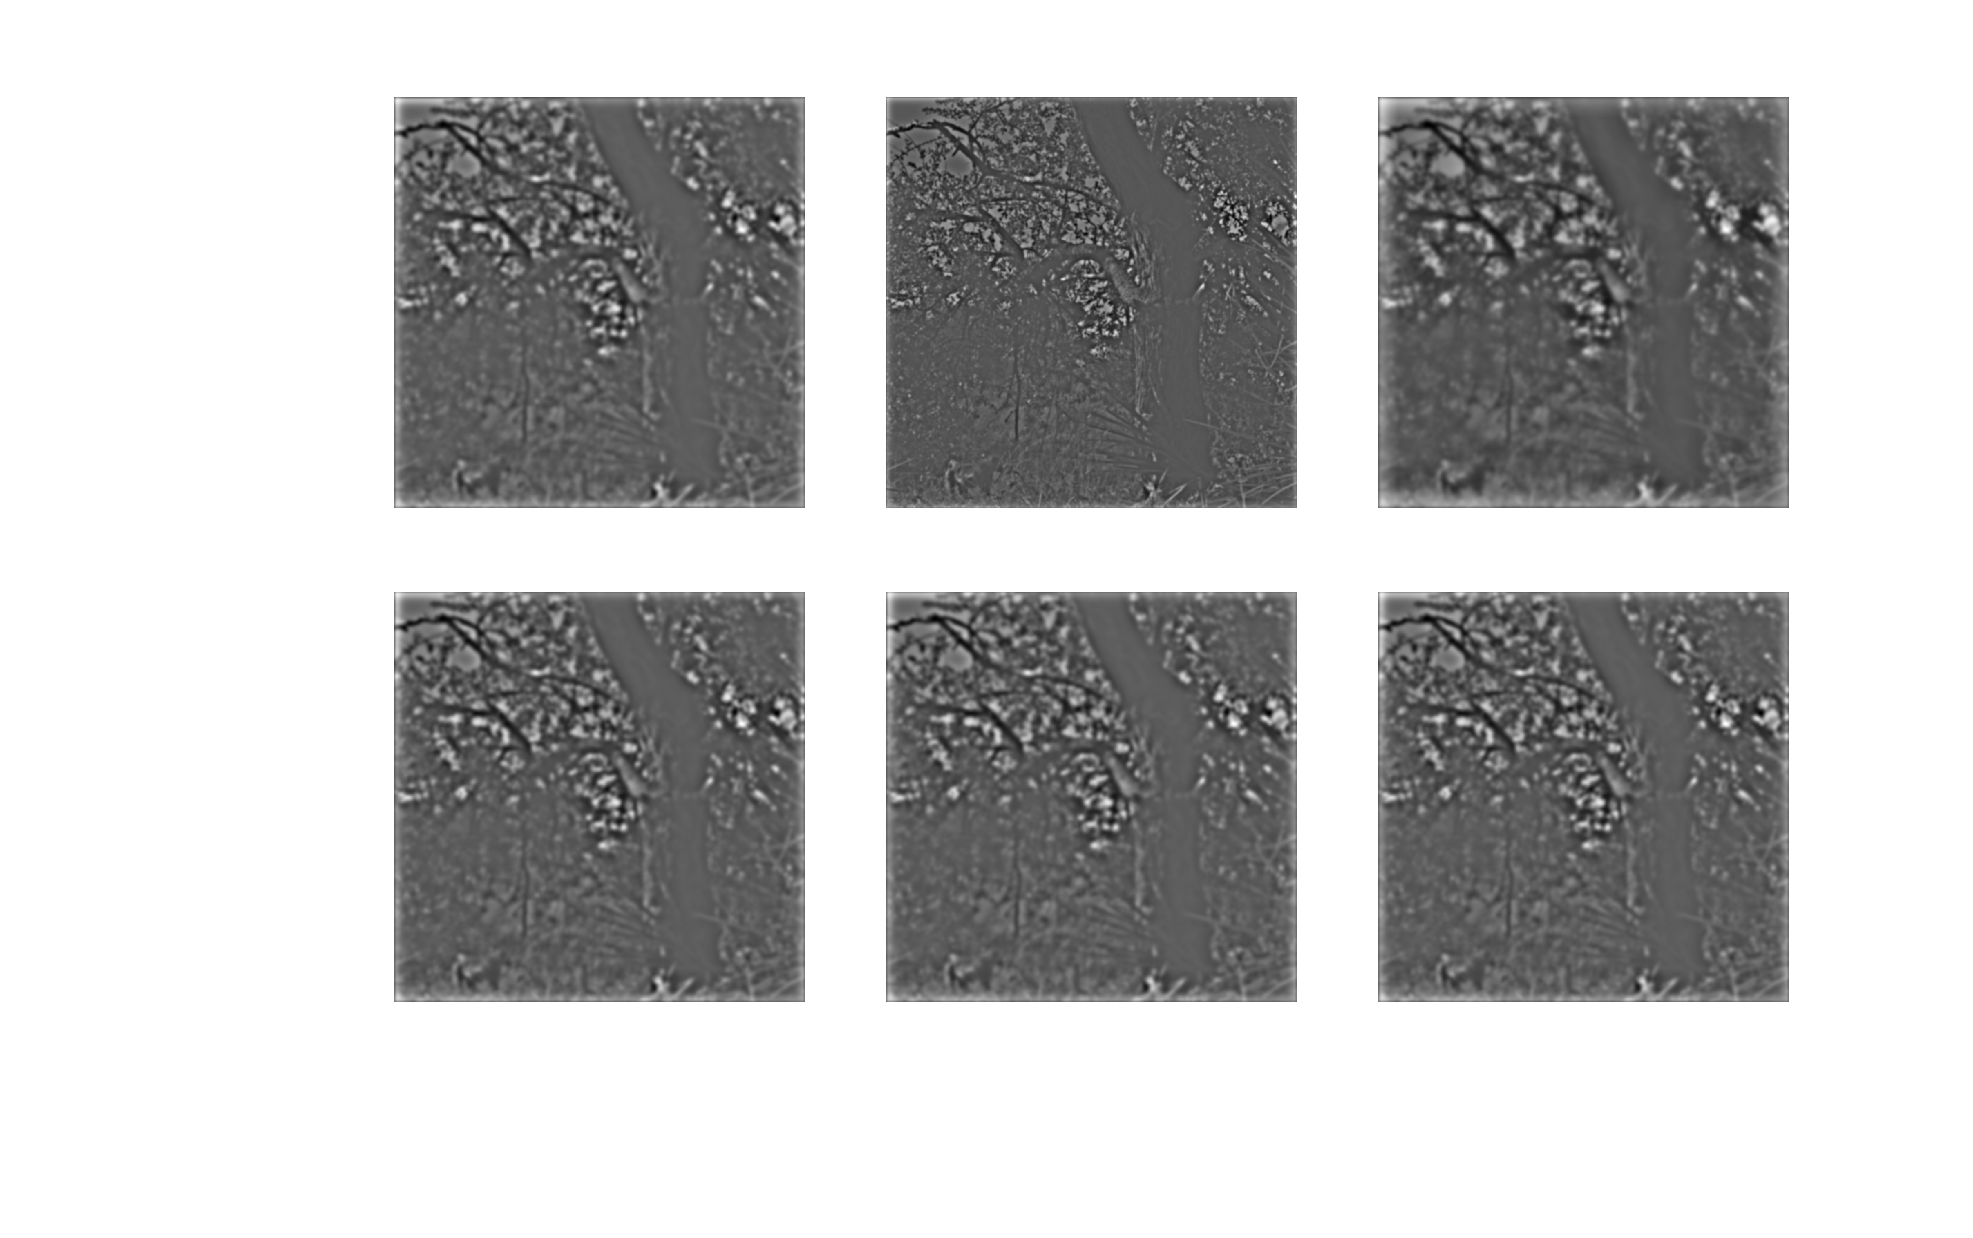

In [81]:
image_id = 1
fig = plt.figure(figsize=(3,2))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(diverse_image_data[image_id][i])
    plt.axis('off')
    
for j in range(3,6):
    plt.subplot(2,3,j+1)
    plt.imshow(homogenous_image_data[image_id][j-3])
    plt.axis('off')

### Stride the input data

In [83]:
from scipy.misc import imresize

In [121]:
homogenous_data = [np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1) for d in homogenous_image_data]
diverse_data = [np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1) for d in diverse_image_data]
groundtruth_data = [imresize(p, (302, 302), interp='bilinear') for p in patches]

In [122]:
groundtruth_data[0].shape

(302, 302)

In [123]:
homogenous_data[0].shape

(302, 302, 3)

In [124]:
diverse_data[0].shape

(302, 302, 3)

In [125]:
homogenous_image_data[0].shape

(3, 907, 907)

# The distortion (compression) is linear, but the best reconstruction can still be nonlinear, if it learns about the structure of natural images. The best reconstruction for whitenoise would be linear.

In [105]:
d = diverse_image_data[0]
blah = np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1)

In [106]:
blah.shape

(302, 302, 3)

/home/lane/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


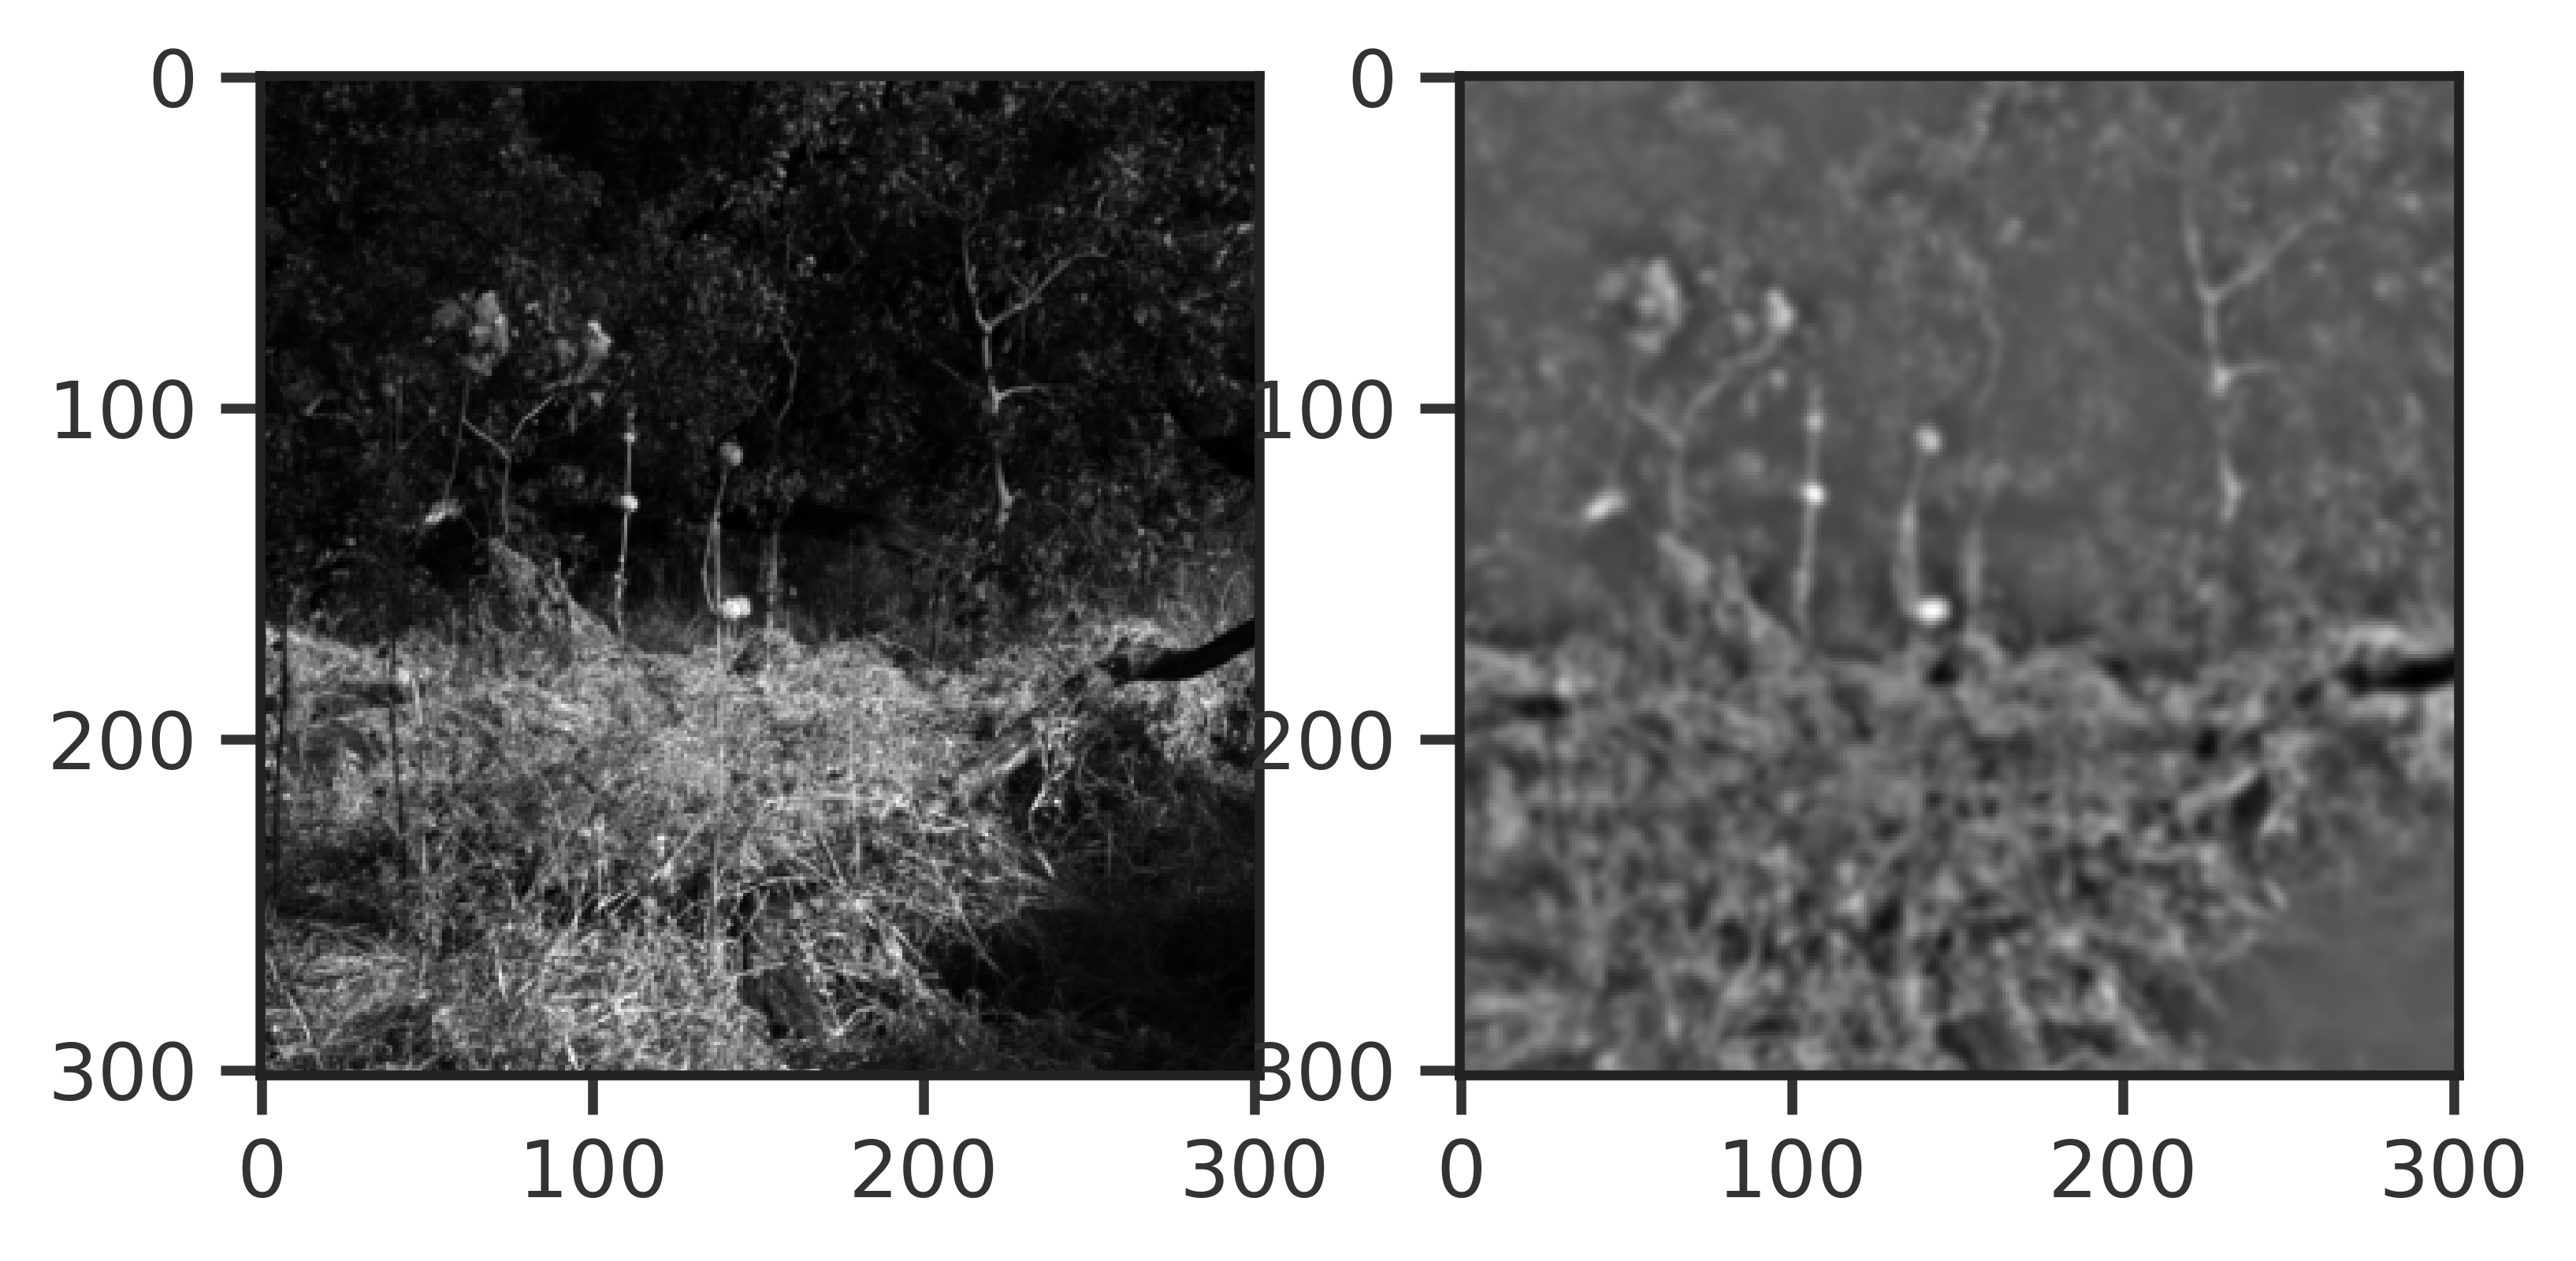

In [99]:
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(groundtruth_data[0])
plt.subplot(1,2,2)
plt.imshow(blah[2])

## Learn a small linear neural network to decode these images.

In [101]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [114]:
max_epochs = 100
batch_size = 1

In [129]:
g = tf.Graph()
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, 302, 302, 3))
    label = tf.placeholder(tf.float32, shape=(302, 302))
    # inputs, num_outputs, kernel_size, stride=1
    layer1 = tf.layers.conv2d_transpose(distortion, 1, 21, padding='valid')
    layer1 = tf.image.resize_bilinear(layer1, [302, 302])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)
    
    step = 0
    with tf.Session() as sess:
        for i in range(max_epochs):
            for inp, patch in zip(homogenous_data, groundtruth_data):
                sess.run(tf.global_variables_initializer())
                update, error = sess.run([train_op, mse], feed_dict={distortion: np.expand_dims(inp, 0),
                                                                     label: patch})
                #print('Error at step %04d is %0.4f' %(step, error))
                step += 1
            print('Error at epoch %03d is %0.4f' %(i, error))

Error at epoch 000 is 2855.2524
Error at epoch 001 is 2855.8201
Error at epoch 002 is 2857.9878
Error at epoch 003 is 2857.8093
Error at epoch 004 is 2856.6082
Error at epoch 005 is 2858.3528
Error at epoch 006 is 2858.2483
Error at epoch 007 is 2858.9028
Error at epoch 008 is 2858.6538
Error at epoch 009 is 2858.9712
Error at epoch 010 is 2856.8230
Error at epoch 011 is 2857.5454
Error at epoch 012 is 2855.3235
Error at epoch 013 is 2859.3101
Error at epoch 014 is 2858.9668
Error at epoch 015 is 2858.4402
Error at epoch 016 is 2858.8440
Error at epoch 017 is 2858.1467
Error at epoch 018 is 2859.8760
Error at epoch 019 is 2858.6990
Error at epoch 020 is 2861.0986
Error at epoch 021 is 2858.3926
Error at epoch 022 is 2861.7786
Error at epoch 023 is 2855.7866
Error at epoch 024 is 2860.6787
Error at epoch 025 is 2859.7939
Error at epoch 026 is 2856.9541
Error at epoch 027 is 2859.5378
Error at epoch 028 is 2859.8882
Error at epoch 029 is 2861.7183
Error at epoch 030 is 2857.4426
Error at

# Fully connected linear layer

In [152]:
homogenous_data = [np.stack([d[i][i:-3+i:24, i:-3+i:24] for i in range(3)], axis=-1) for d in homogenous_image_data]
diverse_data = [np.stack([d[i][i:-3+i:24, i:-3+i:24] for i in range(3)], axis=-1) for d in diverse_image_data]
groundtruth_data = [imresize(p, (38, 38), interp='bilinear') for p in patches]

In [139]:
homogenous_data[0].shape

(38, 38, 3)

In [153]:
groundtruth_data[0].shape

(38, 38)

(-0.5, 37.5, 37.5, -0.5)

/home/lane/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


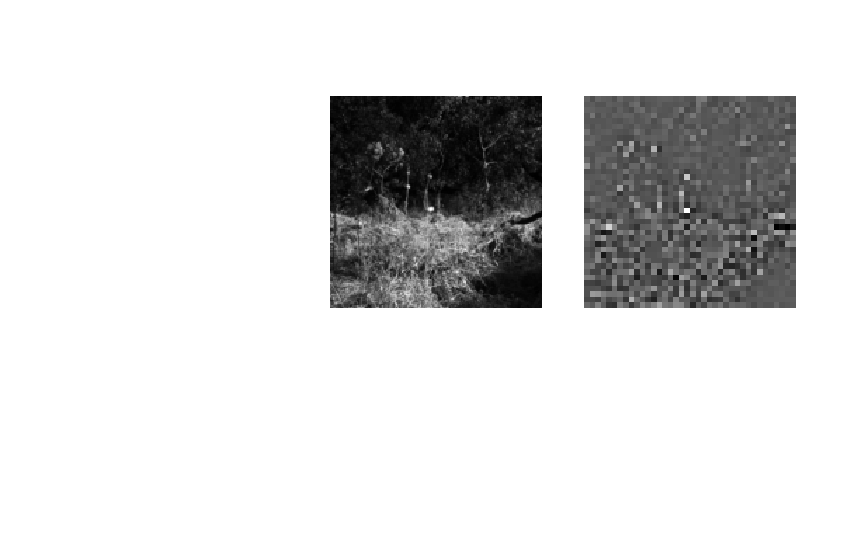

In [148]:
fig = plt.figure(figsize=(1,2))
plt.subplot(1,2,1)
plt.imshow(groundtruth_data[0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(homogenous_data[0][:,:,0])
plt.axis('off')

In [ ]:
height = 38
width = 38
g = tf.Graph()
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, height, width, 3))
    label = tf.placeholder(tf.float32, shape=(height, width))
    # inputs, num_outputs, kernel_size, stride=1
    flattened_input = tf.contrib.layers.flatten(distortion)
    layer1 = tf.layers.dense(flattened_input, height*width)
    layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)
    
    step = 0
    with tf.Session() as sess:
        for i in range(max_epochs):
            for inp, patch in zip(homogenous_data, groundtruth_data):
                sess.run(tf.global_variables_initializer())
                update, error = sess.run([train_op, mse], feed_dict={distortion: np.expand_dims(inp, 0),
                                                                     label: patch})
                #print('Error at step %04d is %0.4f' %(step, error))
                step += 1
            print('Error at epoch %03d is %0.4f' %(i, error))

Error at epoch 000 is 2433.5637
Error at epoch 001 is 2433.3110
Error at epoch 002 is 2433.9531
Error at epoch 003 is 2434.9973
Error at epoch 004 is 2434.1682
Error at epoch 005 is 2434.6106
Error at epoch 006 is 2433.5073
Error at epoch 007 is 2432.7405
Error at epoch 008 is 2433.7710
Error at epoch 009 is 2433.6880
Error at epoch 010 is 2434.2136
Error at epoch 011 is 2434.3015
Error at epoch 012 is 2434.0073
Error at epoch 013 is 2432.0786
Error at epoch 014 is 2434.4045
Error at epoch 015 is 2435.0388
Error at epoch 016 is 2432.6860
Error at epoch 017 is 2433.4165
Error at epoch 018 is 2433.7119
Error at epoch 019 is 2433.9033
Error at epoch 020 is 2433.8884
Error at epoch 021 is 2433.1687
Error at epoch 022 is 2433.0098
Error at epoch 023 is 2432.0544
Error at epoch 024 is 2433.2732
Error at epoch 025 is 2433.3728
Error at epoch 026 is 2433.9390
Error at epoch 027 is 2433.1465
Error at epoch 028 is 2433.9482
Error at epoch 029 is 2433.3823
Error at epoch 030 is 2433.3413
Error at